In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np

In [2]:
# Constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 10

# Directories
train_dir = "./dataset/train"
val_dir = "./dataset/val"
test_dir = "./dataset/test"

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 16938 images belonging to 10 classes.
Found 2425 images belonging to 10 classes.
Found 4846 images belonging to 10 classes.


In [3]:
# Model Creation with Parameter Limitation
from keras_tuner import Hyperband

def build_model(hp):
    model = models.Sequential([
        layers.Conv2D(hp.Choice('filters_1', [32, 64, 128]), (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(hp.Choice('dropout_1', [0.2, 0.3])),

        layers.Conv2D(hp.Choice('filters_2', [64, 128, 256]), (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(hp.Choice('dropout_2', [0.3, 0.4])),

        layers.Flatten(),
        layers.Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'),
        layers.Dropout(hp.Choice('dropout_fc', [0.4, 0.5])),
        layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='tuner_dir_phase2',
    project_name='animals10_cnn_phase2'
)

tuner.search(train_generator, validation_data=val_generator, epochs=10)
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hyperparameters)

Trial 30 Complete [02h 26m 49s]
val_accuracy: 0.20082473754882812

Best val_accuracy So Far: 0.552989661693573
Total elapsed time: 1d 01h 51m 46s


In [4]:
# Training with Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
530/530 [==============================] - 444s 835ms/step - loss: 2.2728 - accuracy: 0.2233 - val_loss: 1.9365 - val_accuracy: 0.3369
Epoch 2/20
530/530 [==============================] - 447s 844ms/step - loss: 1.9181 - accuracy: 0.3196 - val_loss: 1.9205 - val_accuracy: 0.3398
Epoch 3/20
530/530 [==============================] - 595s 1s/step - loss: 1.7870 - accuracy: 0.3754 - val_loss: 1.6790 - val_accuracy: 0.4169
Epoch 4/20
530/530 [==============================] - 538s 1s/step - loss: 1.7197 - accuracy: 0.3977 - val_loss: 1.5999 - val_accuracy: 0.4433
Epoch 5/20
530/530 [==============================] - 527s 994ms/step - loss: 1.6561 - accuracy: 0.4261 - val_loss: 1.4437 - val_accuracy: 0.5072
Epoch 6/20
530/530 [==============================] - 548s 1s/step - loss: 1.6224 - accuracy: 0.4416 - val_loss: 1.4312 - val_accuracy: 0.5027
Epoch 7/20
530/530 [==============================] - 505s 952ms/step - loss: 1.5789 - accuracy: 0.4557 - val_loss: 1.4769 - val_accu

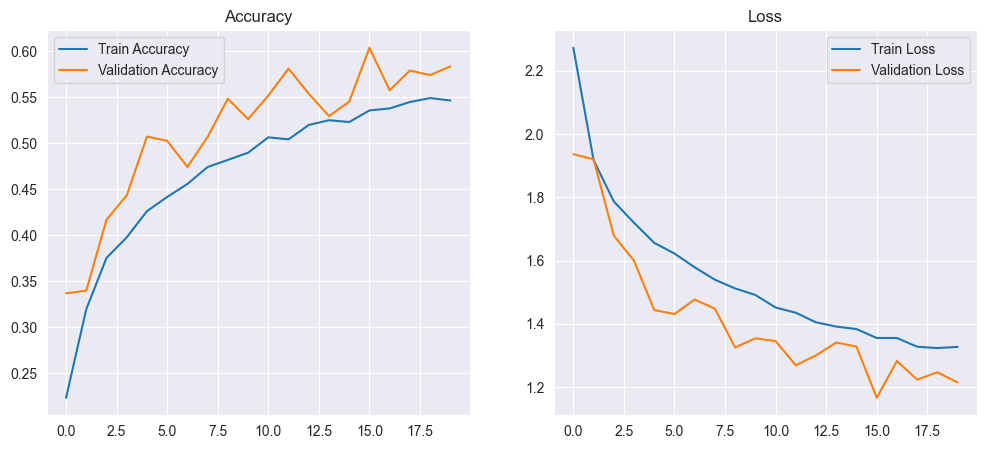

In [5]:
# Plot Learning Curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_learning_curves(history)

In [6]:
# Evaluation
print("Evaluating on Test Set...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Evaluating on Test Set...
152/152 [==============================] - 21s 132ms/step - loss: 1.2129 - accuracy: 0.5743
Test Loss: 1.212924599647522
Test Accuracy: 0.5742880702018738


152/152 [==============================] - 22s 130ms/step


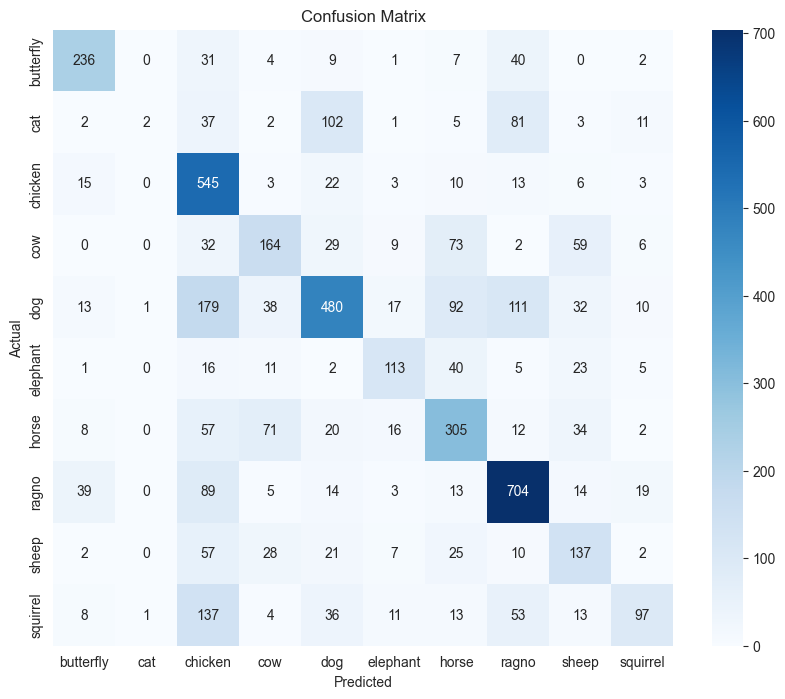

In [7]:
# Confusion Matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

152/152 [==============================] - 20s 134ms/step


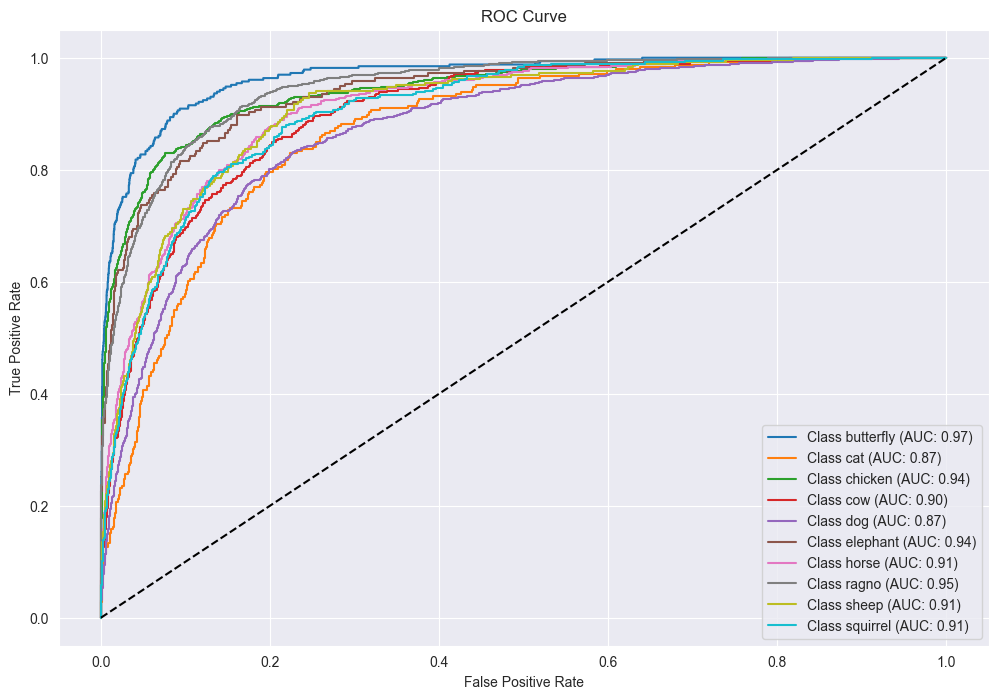

In [8]:
# ROC Curve
y_true_binary = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
y_pred_prob = model.predict(test_generator)

plt.figure(figsize=(12, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {list(test_generator.class_indices.keys())[i]} (AUC: {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [9]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.73      0.72      0.72       330
         cat       0.50      0.01      0.02       246
     chicken       0.46      0.88      0.61       620
         cow       0.50      0.44      0.47       374
         dog       0.65      0.49      0.56       973
    elephant       0.62      0.52      0.57       216
       horse       0.52      0.58      0.55       525
       ragno       0.68      0.78      0.73       900
       sheep       0.43      0.47      0.45       289
    squirrel       0.62      0.26      0.37       373

    accuracy                           0.57      4846
   macro avg       0.57      0.52      0.50      4846
weighted avg       0.59      0.57      0.55      4846



1/1 [==============================] - 0s 403ms/step


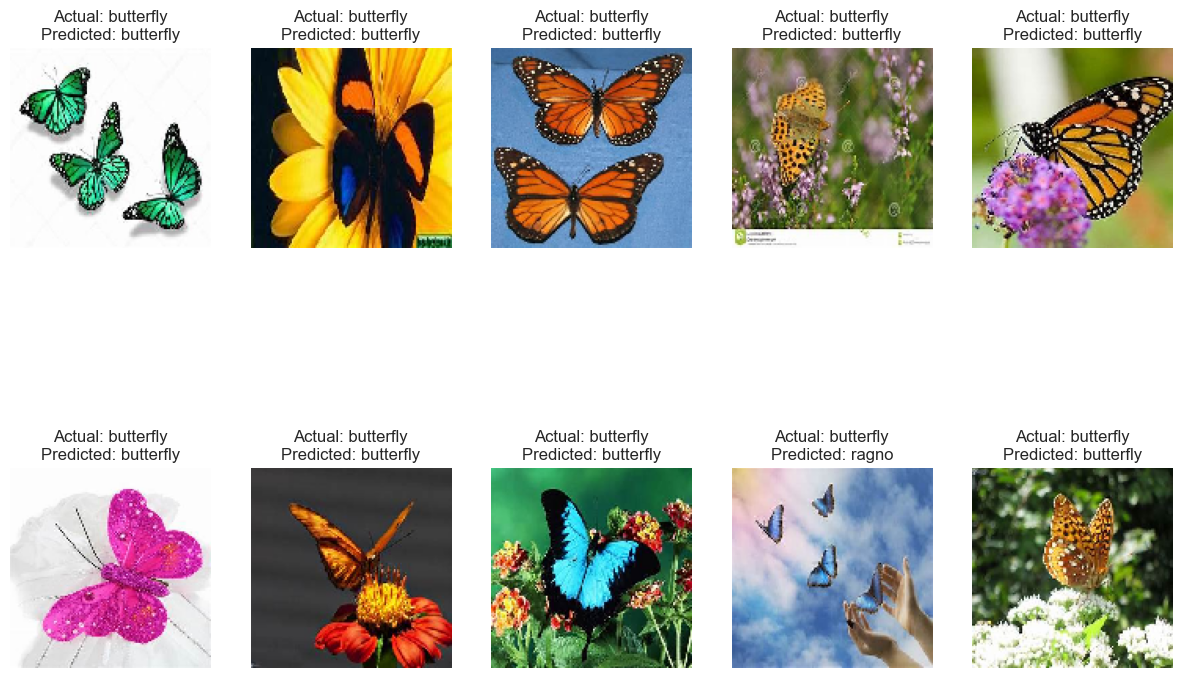

In [10]:
# Visualize Test Predictions
def visualize_predictions(test_generator, model, num_images=10):
    x_test, y_test = next(test_generator)
    y_pred = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[i])
        plt.axis('off')
        plt.title(f"Actual: {list(test_generator.class_indices.keys())[y_true_labels[i]]}\nPredicted: {list(test_generator.class_indices.keys())[y_pred_labels[i]]}")

    plt.show()

visualize_predictions(test_generator, model)